In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/jtsheppard/Unit-2-Project/master/Computers2.csv')
df.head()

,price,speed,hd,ram,screen,cd,multi,premium,ads,trend
0,1499,25,80,4,14,no,no,yes,94,1
1,1795,33,85,2,14,no,no,yes,94,1
2,1595,25,170,4,15,no,no,yes,94,1
3,1849,25,170,8,14,no,no,no,94,1
4,3295,33,340,16,14,no,no,yes,94,1


In [2]:
df.shape

(6259, 10)

In [3]:
df['id'] = df.index
df.head()

,price,speed,hd,ram,screen,cd,multi,premium,ads,trend,id
0,1499,25,80,4,14,no,no,yes,94,1,0
1,1795,33,85,2,14,no,no,yes,94,1,1
2,1595,25,170,4,15,no,no,yes,94,1,2
3,1849,25,170,8,14,no,no,no,94,1,3
4,3295,33,340,16,14,no,no,yes,94,1,4


In [4]:
train = df.loc['0' : '2900']
val = df.loc['2901' : '5800']
test = df.loc['5801' : '6259']

train.shape, val.shape, test.shape

((2901, 11), (2900, 11), (458, 11))

In [5]:
!pip install category_encoders

In [6]:
import category_encoders as ce
from xgboost import XGBRegressor

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

trainval = train
trainval_id = trainval['id'].unique()
train_id, val_id = train_test_split(trainval_id, random_state=42)
train = trainval[trainval.id.isin(train_id)]
target = 'price'
x_train = train.drop(columns=target)
x_val = val.drop(columns=target)
x_test = test.drop(columns=target)
y_test = test[target]
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
y_val_log = np.log1p(y_val)

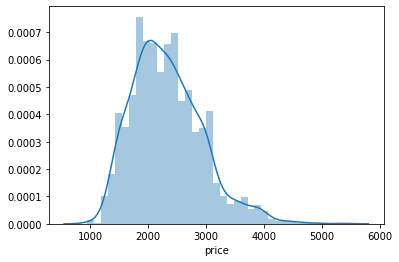

In [8]:
import seaborn as sns
%matplotlib inline
sns.distplot(y_train);

In [9]:
!pip install category_encoders

In [10]:
import category_encoders as ce
from xgboost import XGBRegressor

encoder = ce.OrdinalEncoder()
xtre = encoder.fit_transform(x_train)
xve = encoder.transform(x_val)

x_test = encoder.transform(x_test)


eval_set = [(xtre, y_train_log), (xve, y_val_log)]

model = XGBRegressor(n_estimators=50, n_jobs=-1)
model.fit(xtre, y_train_log, eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)

[23:03:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\tako\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:6.50285	validation_1-rmse:6.42005
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:5.85377	validation_1-rmse:5.76663
[2]	validation_0-rmse:5.2696	validation_1-rmse:5.17658
[3]	validation_0-rmse:4.74385	validation_1-rmse:4.64726
[4]	validation_0-rmse:4.27071	validation_1-rmse:4.16684
[5]	validation_0-rmse:3.8449	validation_1-rmse:3.73354
[6]	validation_0-rmse:3.4617	validation_1-rmse:3.3468
[7]	validation_0-rmse:3.11684	validation_1-rmse:2.99793
[8]	validation_0-rmse:2.8065	validation_1-rmse:2.68013
[9]	validation_0-rmse:2.52726	validation_1-rmse:2.39869
[10]	validation_0-rmse:2.27602	validation_1-rmse:2.14365
[11]	validation_0-rmse:2.04992	validation_1-rmse:1.91171
[12]	validation_0-rmse:1.84653	validation_1-rmse:1.7036
[13]	validation_0-rmse:1.66354	validation_1-rmse:1.51572
[14]	validation_0-rmse:1.49892	validation_1-rmse:1.34801
[1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [11]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

y_pred_log = model.predict(xve)
print('Validation score', rmse(y_val_log, y_pred_log))
y_pred_log = model.predict(x_test)
print('Test score', rmse(y_test_log, y_pred_log))

Validation score 0.17309816352759383
Test score 0.3122703281397495


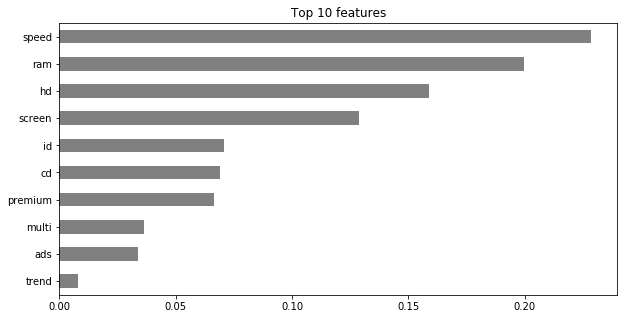

In [12]:
import matplotlib.pyplot as plt
# Get feature importances
importances = pd.Series(model.feature_importances_, xtre.columns)

# Plot feature importances
n = len(xtre.columns)
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [13]:
!pip install eli5

In [14]:
#Permutation Importances plot
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_squared_error',
                                 cv='prefit', n_iter=4, random_state=42)

permuter.fit(xve, y_val_log)
feature_names = xve.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0156 ± 0.0007,ram
0.0110 ± 0.0013,hd
0.0074 ± 0.0004,premium
0.0057 ± 0.0012,speed
0.0022 ± 0.0002,screen
0.0003 ± 0.0001,cd
0 ± 0.0000,id
0 ± 0.0000,trend
0 ± 0.0000,ads
0 ± 0.0000,multi


In [15]:
!pip install pdpbox

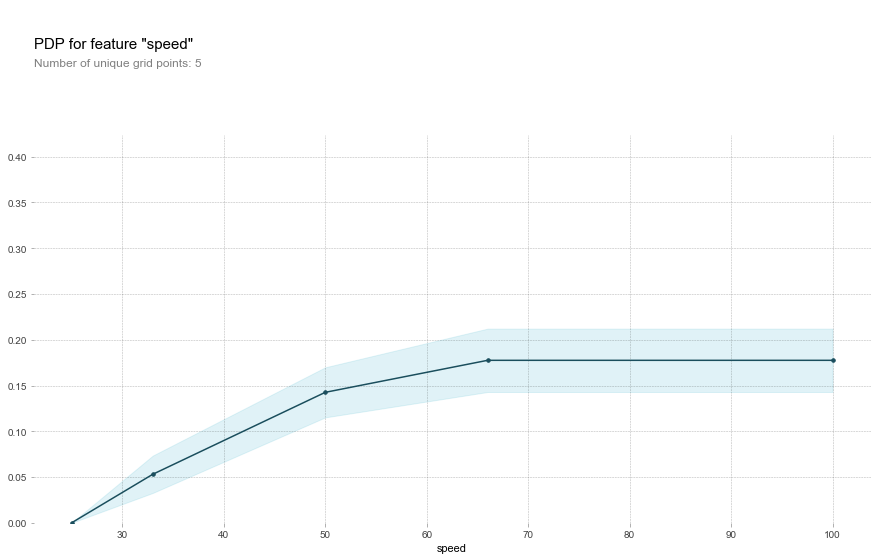

In [16]:
#Partial Dependency Plot, 1 feature isolation
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'speed'

isolated = pdp_isolate(
    model=model, 
    dataset=xve, 
    model_features=xve.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

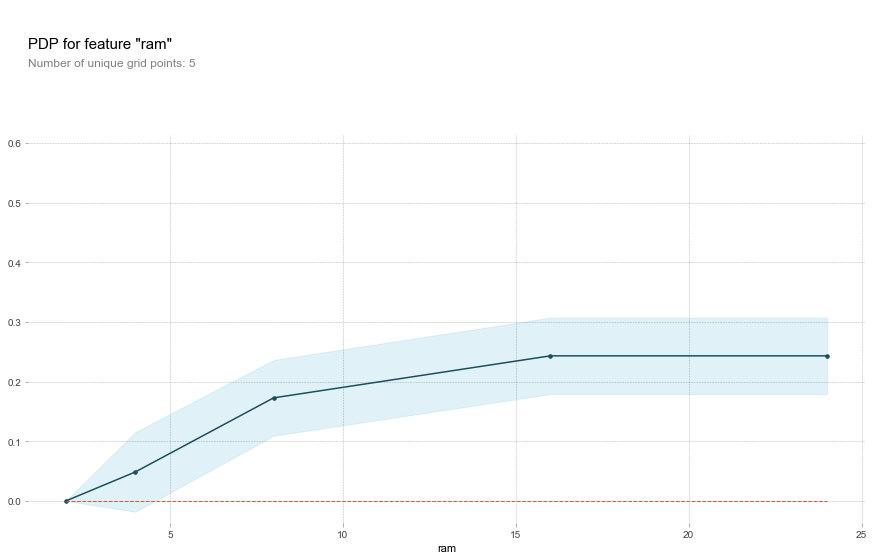

In [19]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'ram'

isolated = pdp_isolate(
    model=model, 
    dataset=xve, 
    model_features=xve.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

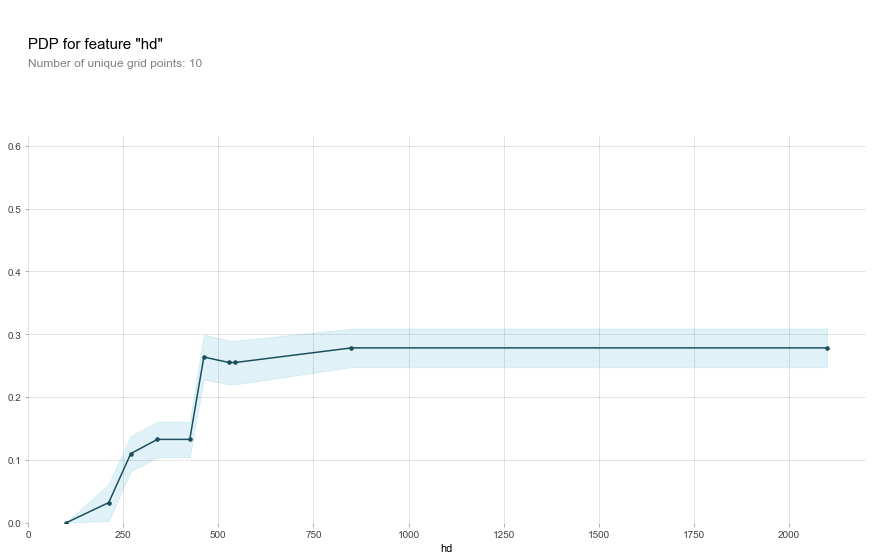

In [20]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'hd'

isolated = pdp_isolate(
    model=model, 
    dataset=xve, 
    model_features=xve.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

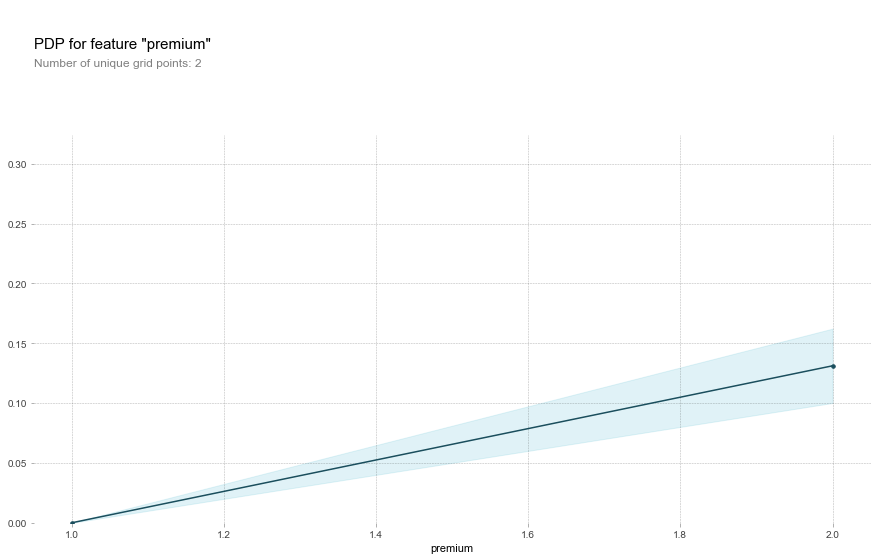

In [22]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'premium'

isolated = pdp_isolate(
    model=model, 
    dataset=xve, 
    model_features=xve.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

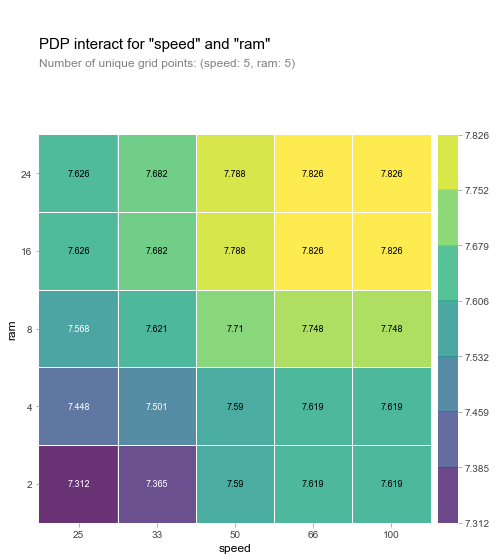

In [18]:
#Partial Dependency Plot, 2 feature interaction
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['speed', 'ram']

interaction = pdp_interact(
    model=model, 
    dataset=xve, 
    model_features=xve.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);